In [2]:
import numpy as np
import pandas as pd
from pyne import data, nucname
from pyne.material import Material
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
results_path = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'

In [4]:
df_idx = 88087

## Pull in Gamma Energies Using PyNE

In [5]:
db = pd.read_pickle(results_path + 'nuc32_activities_scaled_1g_reindex.pkl')

In [6]:
nuc_list = ['ac227', 'am241', 'am243', 'ba133', 'cf249', 'cf252', 'cm243', 'cm244', 
            'cm245', 'cs134', 'cs137', 'eu152', 'eu154', 'ho166m', 'kr85', 'nb94', 
            'np236', 'np237', 'pa231', 'pm146', 'pu236', 'pu238', 'pu239', 'pu240', 
            'ra226', 'sb125', 'th228', 'th229', 'u232', 'u233', 'u234', 'u235']

In [7]:
def manual_gammas(nuclide):
    parent = nucname.id(nuclide)
    decay_c = data.decay_const(parent)
    energies = data.gamma_energy(parent)
    intensities = data.gamma_photon_intensity(parent)
    children = data.gamma_from_to_byparent(parent)
    decay_children = data.decay_data_children(parent)
    decay_branches = data.decay_photon_branch_ratio_byparent(parent)
    
    gammas_result = []
    for i, c in enumerate(children):
        for j, dc in enumerate(decay_children):
            # here is where we skip negative nuclides
            if c[0] > 0:
                if nucname.zzzaaa(c[0]) == nucname.zzzaaa(dc):
                    gammas_result.append((energies[i][0], decay_c*intensities[i][0]*decay_branches[j][0]))
    return gammas_result

In [8]:
gamma_dflist = []
for nuc in nuc_list:
    mat = Material()
    act_bq = db.loc[df_idx][nuc] * 3.7e10
    mat.from_activity({nuc : act_bq})
    gamlist = manual_gammas(nuc)
    gamma = pd.DataFrame(gamlist, columns = ['energy', 'rel_intensity'])
    # get gamma intensity in decay/s
    num_atoms = mat.mass * 6.02e23 / data.atomic_mass(nucname.id(nuc))
    gamma['total_intensity'] = num_atoms * gamma['rel_intensity']
    # get num of decays by multiplying by livetime (600 sec)
    gamma['test_counts'] = gamma['total_intensity'] * 600 # detectors measure for 600 seconds
    gamma['nucID'] = nuc
    gamma['half life (y)'] = data.half_life(nucname.id(nuc)) / 60 / 60 / 24 / 365.25
    gamma_dflist.append(gamma)
all_gammas = pd.concat(gamma_dflist).reset_index(drop=True)

In [10]:
nuc_plot = sorted(all_gammas.nucID.unique())

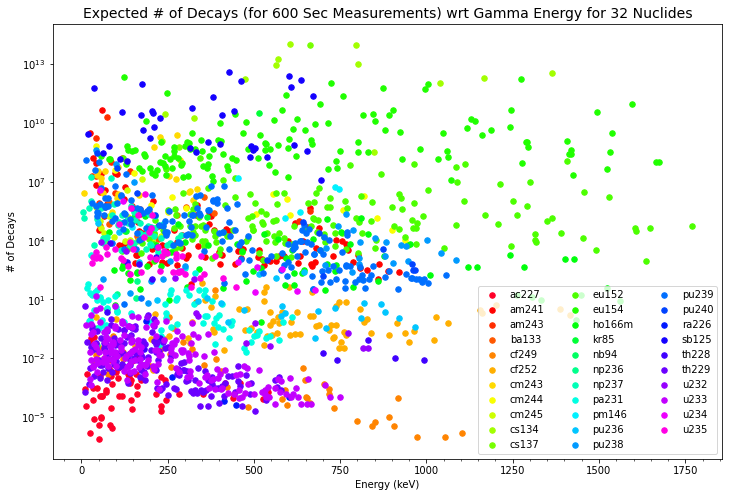

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
num_colors = len(nuc_list)
cm = plt.get_cmap('gist_rainbow')
for i, nuc in enumerate(nuc_list):
    ix = np.where(all_gammas['nucID'] == nuc)
    ax.scatter(all_gammas['energy'].iloc[ix], all_gammas['test_counts'].iloc[ix], 
               color = cm(1.*i/num_colors), label = nuc, s = 30)
#ax.set_xlim(1250, 1400)
#ax.set_ylim(1e0, 1.4e13)
ax.minorticks_on()
plt.title('Expected # of Decays (for 600 Sec Measurements) wrt Gamma Energy for 32 Nuclides', fontsize=14)
plt.yscale('log')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('# of Decays')
ax.legend(loc='best', ncol=3)
plt.show()

## Read in 1 File of Gamma Spectra

Most recent detector: d3

In [9]:
detector_dir = 'detector_response/d1_hpge/'
numcol = 8192
#detector_dir = 'detector_response/d3_czt/'
#numcol = 1024
detector_path = results_path + detector_dir

In [10]:
datidx = '1000'
datgz = detector_path + datidx + '.dat.gz'

In [11]:
def get_energy_bins(bindata):
    with open(bindata) as binfile:
        contents = binfile.readlines()
    binlist = []
    for ebin in contents[1].strip().split(' '):
        binlist.append(float(ebin))
    return binlist
energy_bins = get_energy_bins(detector_path + 'energy_bins.dat')

In [12]:
# reads in all 88 spectra in *.dat.gz into a df, and puts energy bins as columns
df = pd.read_csv(datgz, sep=' ', index_col=0, header=None, usecols=range(0, numcol+1), names=['DbIdx']+energy_bins, compression='gzip')

In [13]:
df.tail(1)

,0.000000,0.359110,0.718220,1.077330,1.436440,1.795551,2.154661,2.513771,2.872881,3.231991,...,2938.239000,2938.598000,2938.957000,2939.316000,2939.676000,2940.034000,2940.394000,2940.753000,2941.112000,2941.471000
DbIdx,,,,,,,,,,,,,,,,,,,,,
88087,0.0,0.0,0.0,2.407328,102.6924,2035.435,19186.73,89369.48,210529.9,319738.3,...,0.036704,0.036637,0.036567,0.036492,0.036391,0.03632,0.036231,0.036129,0.036017,0.035899


## Plot a Test Spectrum

In [14]:
def plot_spectrum(df_idx):
    fig, ax = plt.subplots()
    ax.plot(energy_bins, df.loc[df_idx], linewidth = 2)
    ax.set_title('Spectrum, Idx: ' + str(df_idx), fontsize=12)
    ax.set_xlim(0, 1700)
    ax.set_ylim(0, 1e6)
    plt.show()

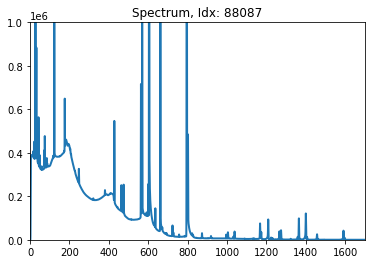

In [15]:
plot_spectrum(df_idx)

## Plot Spectrum with Energy Bin Windows

In [9]:
min_decays = 5e10 #5e8
exp_lines = all_gammas.loc[all_gammas['test_counts'] > min_decays].sort_values('energy')
en_list = exp_lines['energy'].tolist()
len(en_list)

31

In [10]:
exp_lines[['nucID', 'half life (y)']].drop_duplicates()

,nucID,half life (y)
4264,sb125,2.75856
3647,eu154,8.60100
3459,cs134,2.06520
3470,cs137,30.08000


In [11]:
min_decays = 5e8
exp_lines = all_gammas.loc[all_gammas['test_counts'] > min_decays].sort_values('energy')
exp_lines[['nucID', 'half life (y)']].drop_duplicates()

,nucID,half life (y)
4263,sb125,2.75856
68,am241,432.60000
3422,cm244,18.10000
190,am243,7364.00000
3647,eu154,8.60100
3397,cm243,29.10000
3456,cs134,2.06520
3469,cs137,30.08000
3853,kr85,10.73900


In [40]:
#import pickle
#en_list_pkl = 'idx88087_energy_list_31.pkl'
#with open(results_path + 'detector_response/' + en_list_pkl, 'wb') as filehandle:
#    pickle.dump(en_list, filehandle)

In [16]:
en_delta = 3 #energy window in keV

In [27]:
def plot_spectrum_withlines(df_idx):
    fig, ax = plt.subplots(4, figsize=(18, 18))
    fig.suptitle('Spectrum, Idx: ' + str(df_idx), fontsize=18)
    for a in ax:
        a.plot(energy_bins, df.loc[df_idx], linewidth = 3)
        a.minorticks_on()
        for en in en_list:
            a.axvline(x=en, color='r', linewidth=0.5)
            a.axvspan(en - en_delta, en + en_delta, color='grey', alpha=0.3)
    ax[0].set_title('Low Energy', fontsize=12)
    ax[0].set_xlim(0, 450)
    ax[0].set_ylim(0, 1e6)
    ax[1].set_title('Med Energy', fontsize=12)
    ax[1].set_xlim(450, 900)
    ax[1].set_ylim(0, 2e5)
    ax[2].set_title('High Energy', fontsize=12)
    ax[2].set_xlim(900, 1700)
    ax[2].set_ylim(0, 5e4)
    ax[3].set_title('XHigh Energy', fontsize=12)
    ax[3].set_xlim(1700, 2500)
    ax[3].set_ylim(0, 1e3)
    plt.show()

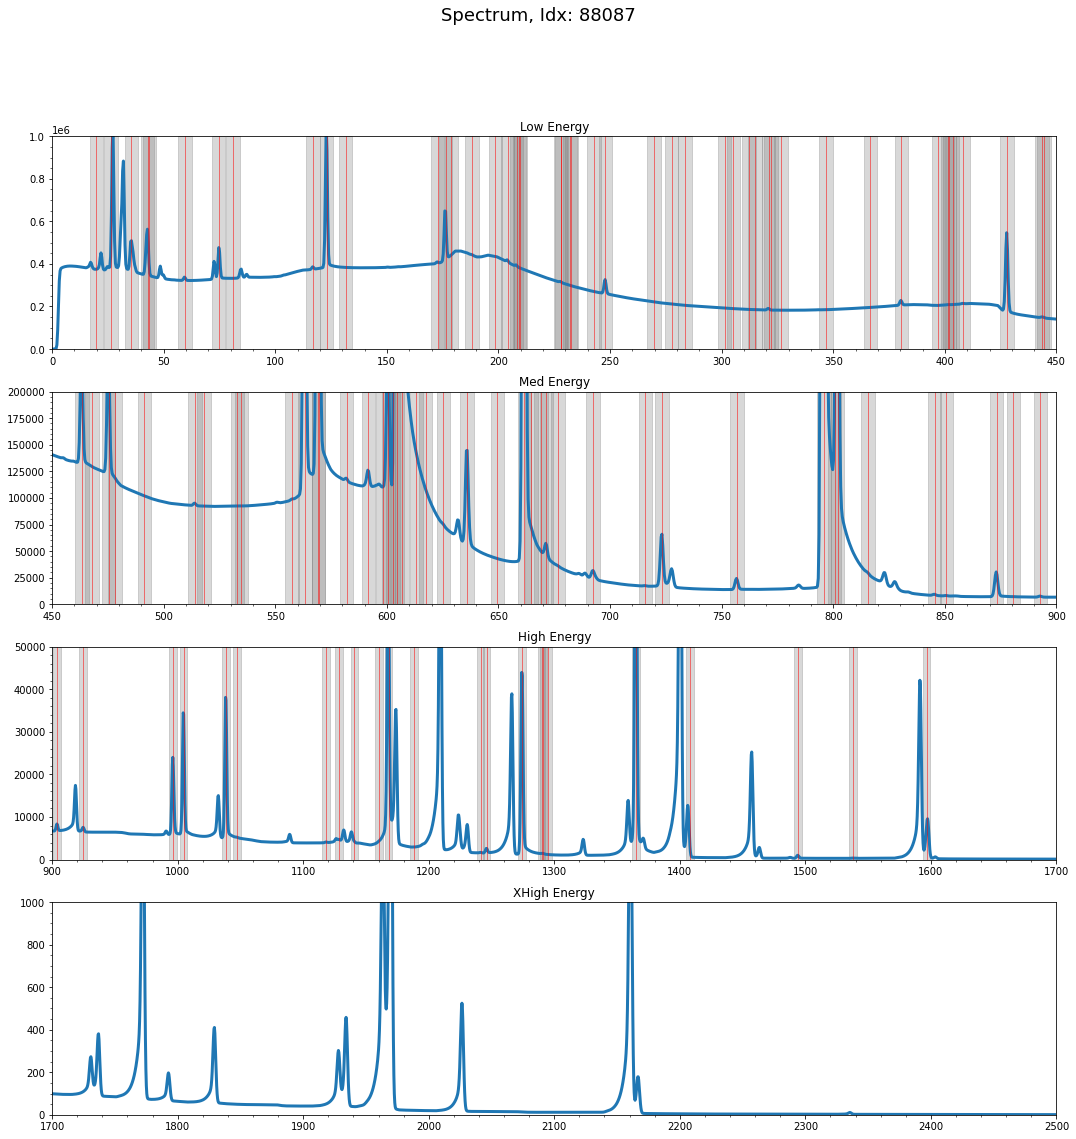

In [28]:
df_idx = 88087
plot_spectrum_withlines(df_idx)

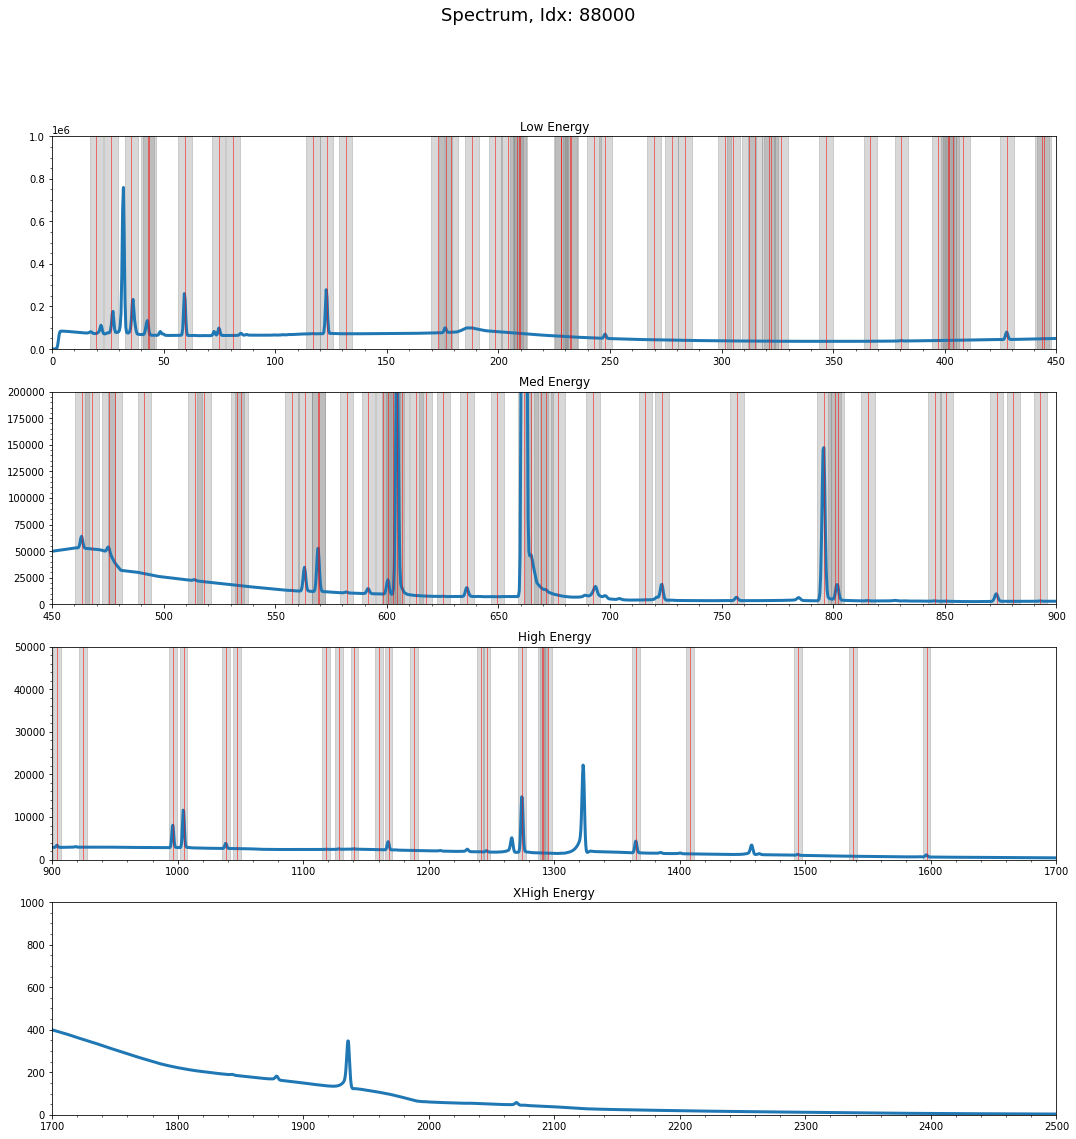

In [29]:
df_idx = 88000
plot_spectrum_withlines(df_idx)

### Find missing peaks

In [ ]:
    # missing peak line
    ax[2].axvline(x=1318, color='g', linewidth=2) # eu152 line
    ax[2].axvline(x=1323, color='c', linewidth=2) # cf252 line
    ax[2].axvline(x=1328, color='c', linewidth=2) # cf252 line
    # missing lines, high energy
    ax[2].axvline(x=1090, color='g', linewidth=2) # eu152 line very likely
    ax[2].axvline(x=1230, color='m', linewidth=2) # no gamma energy in dataframe
    ax[2].axvline(x=1266, color='m', linewidth=2) # no gamma energy in dataframe
    # missing lines, low energy
    ax[0].axvline(x=17, color='m', linewidth=2) # 
    ax[0].axvline(x=22, color='m', linewidth=2) # 
    ax[0].axvline(x=49, color='m', linewidth=2) # 
    ax[0].axvline(x=73, color='m', linewidth=2) # 
    ax[0].axvline(x=75, color='m', linewidth=2) # 
    ax[0].axvline(x=85, color='m', linewidth=2) # 
    ax[0].axvline(x=87, color='m', linewidth=2) # 

In [28]:
all_gammas.loc[(all_gammas['energy'] > 1318) & (all_gammas['energy'] < 1330)]

,energy,intensity,total_intensity,test_counts,nucID,half life (y)
3246,1320.40,NaN,NaN,NaN,cf252,2.645
3247,1321.90,NaN,NaN,NaN,cf252,2.645
3248,1323.20,NaN,NaN,NaN,cf252,2.645
3249,1328.02,NaN,NaN,NaN,cf252,2.645
3250,1328.90,NaN,NaN,NaN,cf252,2.645
3630,1318.38,2.549341e-12,12.087134,7252.280484,eu152,13.517


In [31]:
#1266!!!
all_gammas.loc[(all_gammas['energy'] > 1263) & (all_gammas['energy'] < 1269)]

,energy,intensity,total_intensity,test_counts,nucID,half life (y)
3224,1263.1,NaN,NaN,NaN,cf252,2.645


## Process Spectra into Window Bin Counts

- need to run the processing loop in a script and not here (~2 hrs to run in nb)
- important to check/test: indices match. The index is the only thing linking these spectra to their labels in a diff .pkl. have the .dat files being processed in order, and the ignore_index is default/false on the df.append step

other notes

- en_delta is not +/- 2keV. This window size can be tuned.
- d1: number of windows is currently 113 (with the criteria being 5e8 decays/measurement as calculated using PyNE above). This can also be tuned. Can also manually include the missing peaks. Starter list below.
- originally thought I could impose a min counts requirement, but that won't be possible with the variation in spectra counts among the entries & the large differences in low v high energy counts within a spectrum
- note that en_list was created by using the activities of a specific spent fuel measurement in the db (I chose one that had high counts and more visible peaks to get a more "complete" list)

In [ ]:
# need to figure this out before we append anything 
append_en_list = [1323, 1090, 1231, 1266, 17, 22, 49, 73, 75, 85, 87]

In [17]:
def find_nearest_energy(target_en):
    close_idx = (np.abs(np.asarray(energy_bins) - target_en)).argmin()
    return close_idx

In [18]:
# loop moved to spectra process script 

In [22]:
# output of `ls -1 | wc -l` in d1 directory is 5008,
# so 5007 dat files (ie exclude 1 file, energy_bins.dat): 0 --> 5006 range
for i in range(0, 50):
    gz = detector_path + str(i) + '.dat.gz'
    gzdf = pd.read_csv(gz, sep=' ', index_col=0, header=None, usecols=range(0, 8193), names=['DbIdx',]+energy_bins, compression='gzip')
    windf = pd.DataFrame(columns=en_list)
    for en in en_list:
        low_idx = find_nearest_energy(en - en_delta)
        high_idx = find_nearest_energy(en + en_delta)
        windf[en] = gzdf.iloc[:, low_idx:high_idx+1].sum(axis=1)
    if i == 0:
        peaksdf = windf.copy()
    else:
        peaksdf = peaksdf.append(windf)

In [26]:
#pd.to_pickle(loopdf, 'd1_hpge_spectra_peaks.pkl')
actsdf = pd.read_pickle(results_path + 'nuc32_activities_scaled_1g_reindex.pkl')

In [30]:
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor',
       'AvgPowerDensity', 'ModDensity', 'UiWeight']

In [38]:
sub_actsdf = actsdf.iloc[0:peaksdf.index.tolist()[-1]+1][lbls]

In [42]:
labeled_peaksdf = pd.concat([sub_actsdf, peaksdf], axis=1)

In [43]:
labeled_peaksdf.to_pickle('test.pkl.gz', compression='gzip')

In [44]:
labeled_peaksdf.to_pickle('test.pkl')